## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- Create 4 models using the following algorithms:
    - Random Forest
    - Gradient Boosting
    - XGBoost
    - LightGBM
    - MLP
- Train each model on the training data
- Take the most predicted class from each model
- Use the majority vote to make the final prediction

#### Findings:

Selected Features after the correlation analysis:


In [71]:
# downgrade sklearn to 1.3.2
#! pip install scikit-learn==1.3.2
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [72]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'raw/'
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_NAME = f"cm_ensemble_v4_best_features_{BALANCING_TYPE}.csv"

In [73]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

## Train different models to indentify the best one

In [74]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------

SEED = 42

MODELS = {
    "XGBoost": XGBClassifier(random_state=SEED),
    "CatBoost": CatBoostClassifier(random_state=SEED, verbose=0),
    "LightGBM": LGBMClassifier(random_state=SEED),
    "MLP_Basic": MLPClassifier(
        hidden_layer_sizes=(
            128,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Ultra": MLPClassifier(
        hidden_layer_sizes=(
            512,
            256,
            128,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Large": MLPClassifier(
        hidden_layer_sizes=(
            256,
            128,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Small": MLPClassifier(
        hidden_layer_sizes=(
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
        max_iter=500,
    ),
    "MLP_Tiny": MLPClassifier(
        hidden_layer_sizes=(
            32,
            16,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
        max_iter=500,
    ),
    "MLP_Reverse": MLPClassifier(
        hidden_layer_sizes=(32, 64, 128, 256, 512, 256, 128, 64, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Bottleneck": MLPClassifier(
        hidden_layer_sizes=(
            512,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Rollercoaster": MLPClassifier(
        hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Hourglass": MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64, 32, 64, 128, 256, 512),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Pyramid": MLPClassifier(
        hidden_layer_sizes=(1024, 512, 256, 128, 128, 128, 64, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Wide": MLPClassifier(
        hidden_layer_sizes=(1024, 1024),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_WideUltra": MLPClassifier(
        hidden_layer_sizes=(1024, 1024, 128, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Sparse": MLPClassifier(
        hidden_layer_sizes=(32, 16, 8),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "MLP_Dropout": MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
        early_stopping=True,
        alpha=0.01,
    ),
    "MLP_Ensemble1": VotingClassifier(
        estimators=[
            (
                "MLP_Basic",
                MLPClassifier(
                    hidden_layer_sizes=(128, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Large",
                MLPClassifier(
                    hidden_layer_sizes=(256, 128, 64),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(512, 256, 128),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
    "MLP_Ensemble2": VotingClassifier(
        estimators=[
            ("RandomForest", RandomForestClassifier(random_state=SEED)),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(
                        512,
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
    "MLP_Ensemble3": VotingClassifier(
        estimators=[
            (
                "MLP_Rollercoaster",
                MLPClassifier(
                    hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Large",
                MLPClassifier(
                    hidden_layer_sizes=(
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
    "MLP_Ensemble4": VotingClassifier(
        estimators=[
            (
                "MLP_Rollercoaster",
                MLPClassifier(
                    hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Large",
                MLPClassifier(
                    hidden_layer_sizes=(
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(
                        512,
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
    "MLP_Ensemble5": VotingClassifier(
        estimators=[
            ("RandomForest", RandomForestClassifier(random_state=SEED)),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(
                        512,
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Rollercoaster",
                MLPClassifier(
                    hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
    "MLP_Ensemble6": VotingClassifier(
        estimators=[
            (
                "MLP_Rollercoaster",
                MLPClassifier(
                    hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Large",
                MLPClassifier(
                    hidden_layer_sizes=(
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(
                        512,
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Wide",
                MLPClassifier(
                    hidden_layer_sizes=(1024, 1024),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
}


METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "MCC": matthews_corrcoef,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
results_df_train = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}
cm_dict_train = {}

Training XGBoost

Training CatBoost

Training LightGBM

Training MLP_Basic

Training MLP_Ultra

Training MLP_Large

Training MLP_Small

Training MLP_Tiny

Training MLP_Reverse

Training MLP_Bottleneck

Training MLP_Rollercoaster

Training MLP_Hourglass

Training MLP_Pyramid

Training MLP_Wide

Training MLP_WideUltra

Training MLP_Sparse

Training MLP_Dropout

Training MLP_Ensemble1

Training MLP_Ensemble2

Training MLP_Ensemble3

Training MLP_Ensemble4

Training MLP_Ensemble5

Training MLP_Ensemble6



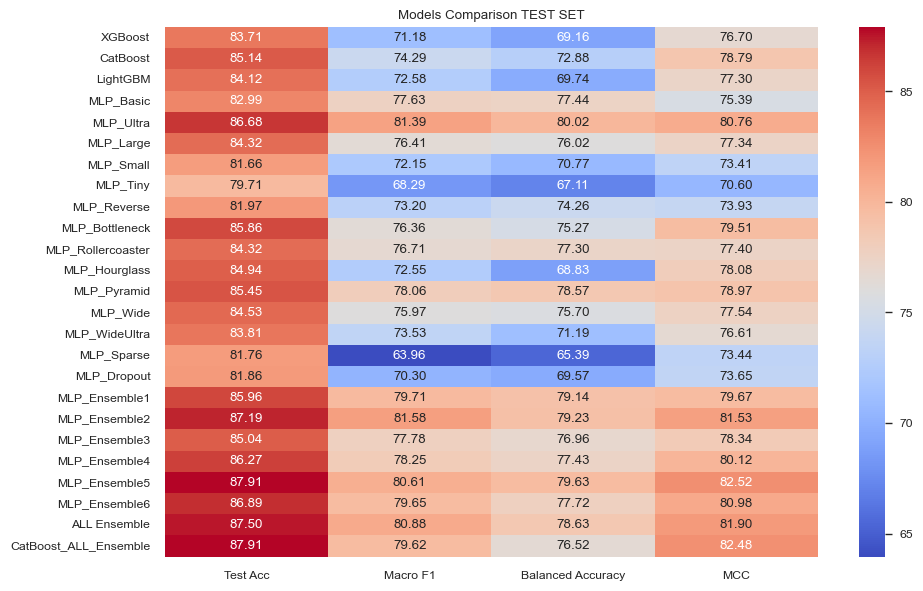

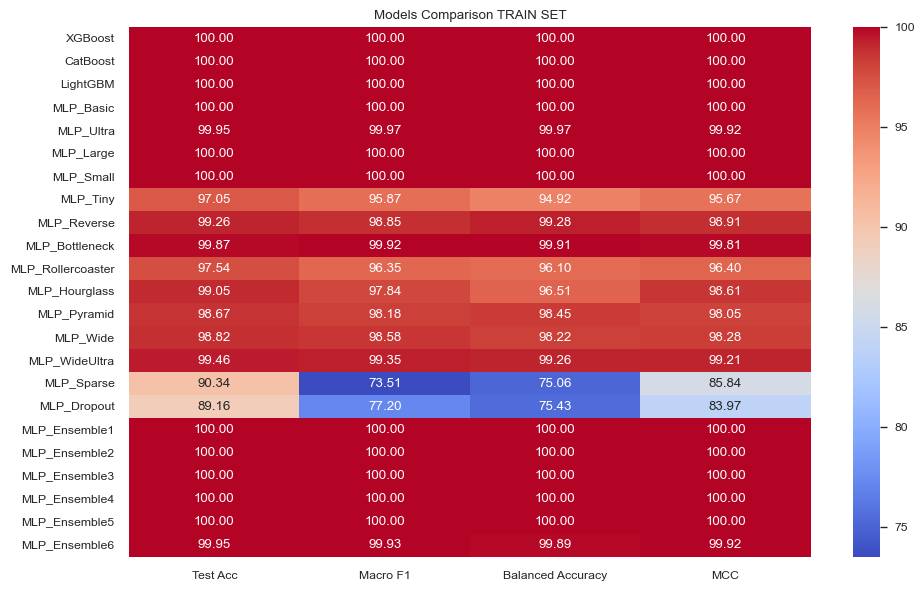

In [75]:
# train each model, store predictions and take the most predicted class as final perdiction
y_pred_all_test = np.zeros((full_data["test"]["y"].shape[0], 1))
y_pred_all_train = np.zeros((full_data["train"]["y"].shape[0], 1))

for model_name, model in MODELS.items():
    print(f"Training {model_name}\n")
    y_pred_local_test = []
    y_pred_local_train = []

    # load the model if it exists
    if os.path.exists(MODELS_PATH + model_name + f"_{BALANCING_TYPE}.joblib"):
        model = joblib.load(MODELS_PATH + model_name + f"_{BALANCING_TYPE}.joblib")
    else:
        # train the model
        model.fit(full_data["train"]["X"], full_data["train"]["y"])

        # save the model
        joblib.dump(model, MODELS_PATH + model_name + f"_{BALANCING_TYPE}.joblib")

    y_pred_test = model.predict(full_data["test"]["X"])
    y_pred_local_test.append(y_pred_test)

    y_pred_train = model.predict(full_data["train"]["X"])
    y_pred_local_train.append(y_pred_train)

    y_true = full_data["test"]["y"]
    for metric_name, metric in METRICS.items():
        if "macro" in metric_name.lower():
            result_df.loc[model_name, metric_name] = metric(
                y_true, y_pred_test, average="macro"
            )
            results_df_train.loc[model_name, metric_name] = metric(
                full_data["train"]["y"], y_pred_train, average="macro"
            )

        else:
            result_df.loc[model_name, metric_name] = metric(y_true, y_pred_test)
            results_df_train.loc[model_name, metric_name] = metric(
                full_data["train"]["y"], y_pred_train
            )

    cm_dict[model_name] = confusion_matrix(y_true, y_pred_test)
    cm_dict_train[model_name] = confusion_matrix(full_data["train"]["y"], y_pred_train)

    y_pred_all_test = np.hstack(
        [y_pred_all_test, np.vstack(y_pred_local_test).reshape(-1, 1)]
    )
    y_pred_all_train = np.hstack(
        [y_pred_all_train, np.vstack(y_pred_local_train).reshape(-1, 1)]
    )

# drop the first column
y_pred_all_test = y_pred_all_test[:, 1:]
y_pred_all_train = y_pred_all_train[:, 1:]

# ENSEMBLE MAJORITY VOTING
# take the most predicted class as final perdiction
y_pred_ensemble = []
for row in y_pred_all_test:
    y_pred_ensemble.append(np.argmax(np.bincount(row.astype(int))))
y_pred = np.array(y_pred_ensemble)
y_true = full_data["test"]["y"]
for metric_name, metric in METRICS.items():
    if "macro" in metric_name.lower():
        result_df.loc["ALL Ensemble", metric_name] = metric(
            y_true, y_pred, average="macro"
        )
    else:
        result_df.loc["ALL Ensemble", metric_name] = metric(y_true, y_pred)
cm_dict["ALL Ensemble"] = confusion_matrix(y_true, y_pred)


# ENSEMBLE WITH NEURAL NETWORK
# train a neural network on the predictions of the models
model = CatBoostClassifier(random_state=SEED, verbose=0)
model.fit(y_pred_all_train, full_data["train"]["y"])
y_pred = model.predict(y_pred_all_test)
y_true = full_data["test"]["y"]
for metric_name, metric in METRICS.items():
    if "macro" in metric_name.lower():
        result_df.loc["CatBoost_ALL_Ensemble", metric_name] = metric(
            y_true, y_pred, average="macro"
        )
    else:
        result_df.loc["CatBoost_ALL_Ensemble", metric_name] = metric(y_true, y_pred)
cm_dict["CatBoost_ALL_Ensemble"] = confusion_matrix(y_true, y_pred)


# save the results
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
# save the confusion matrices
np.save(MODELS_RESULTS + CM_NAME, cm_dict)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(
    result_df.astype(float) * 100, annot=True, cmap="coolwarm", ax=ax, fmt=".2f"
)
ax.set_title("Models Comparison TEST SET")
plt.tight_layout()
plt.show()

# plot the training results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(
    results_df_train.astype(float) * 100, annot=True, cmap="coolwarm", ax=ax, fmt=".2f"
)
ax.set_title("Models Comparison TRAIN SET")
plt.tight_layout()
plt.show()

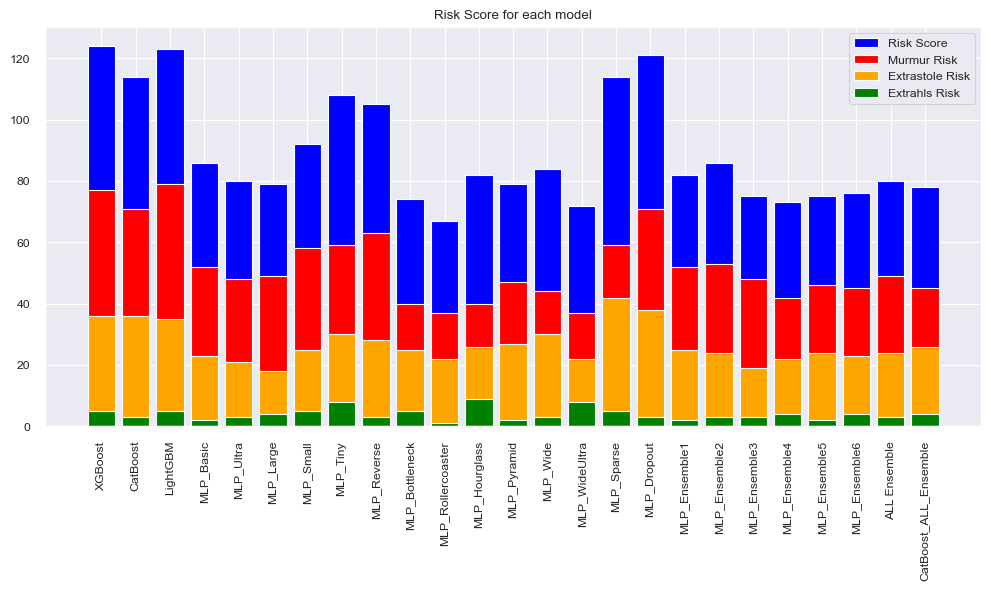

In [76]:
# for all the confusion matrix, take the sum of column 4 minus the cell 4,4
risk_score_list, murmur_risk_list, extrahl_risk_list, extrastole_risk_list = [], [], [], []
for model in cm_dict.keys():
    cm = cm_dict[model]
    risk_score = np.sum(cm[:, 3]) - cm[3, 3] #diseases classified as normal
    risk_score_list.append(risk_score)
    
    # disease 2 (murmurs) classified as normal
    murmur_risk = cm[2, 3]
    murmur_risk_list.append(murmur_risk)
    # disease 1 (extrahls) classified as normal
    extrahl_risk = cm[1, 3]
    extrahl_risk_list.append(extrahl_risk)
    # disease 4 (extrastoles) classified as normal
    extrastole_risk = cm[4, 3]
    extrastole_risk_list.append(extrastole_risk)
    
    
# plot the results in unique bar plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(np.arange(len(risk_score_list)), risk_score_list, label='Risk Score', color='blue')
ax.bar(np.arange(len(murmur_risk_list)), murmur_risk_list, label='Murmur Risk', color='red')
ax.bar(np.arange(len(extrastole_risk_list)), extrastole_risk_list, label='Extrastole Risk', color='orange')
ax.bar(np.arange(len(extrahl_risk_list)), extrahl_risk_list, label='Extrahls Risk', color='green')
ax.set_xticks(np.arange(len(risk_score_list)))
ax.set_xticklabels(list(cm_dict.keys()), rotation=90)
ax.set_title('Risk Score for each model')
ax.legend()
plt.tight_layout()
plt.show()

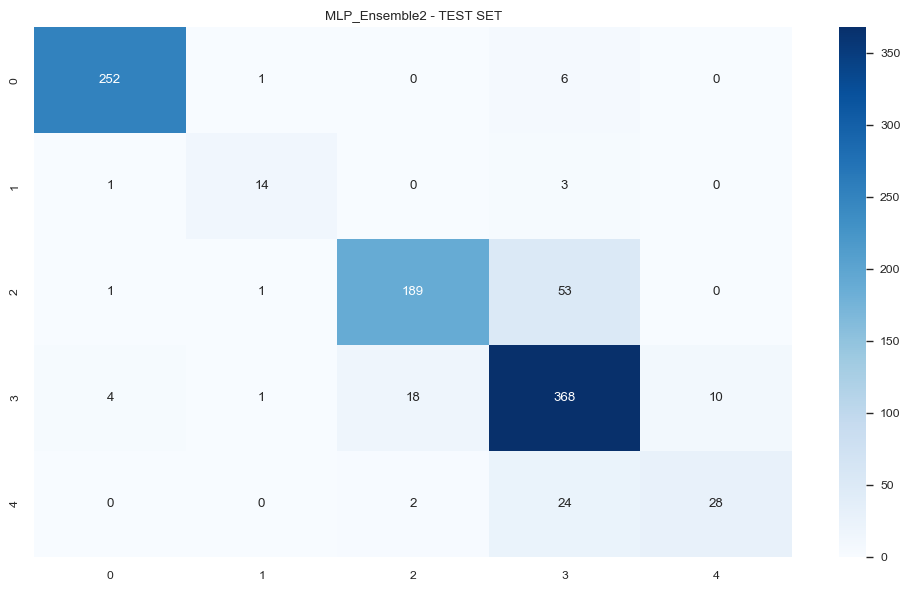

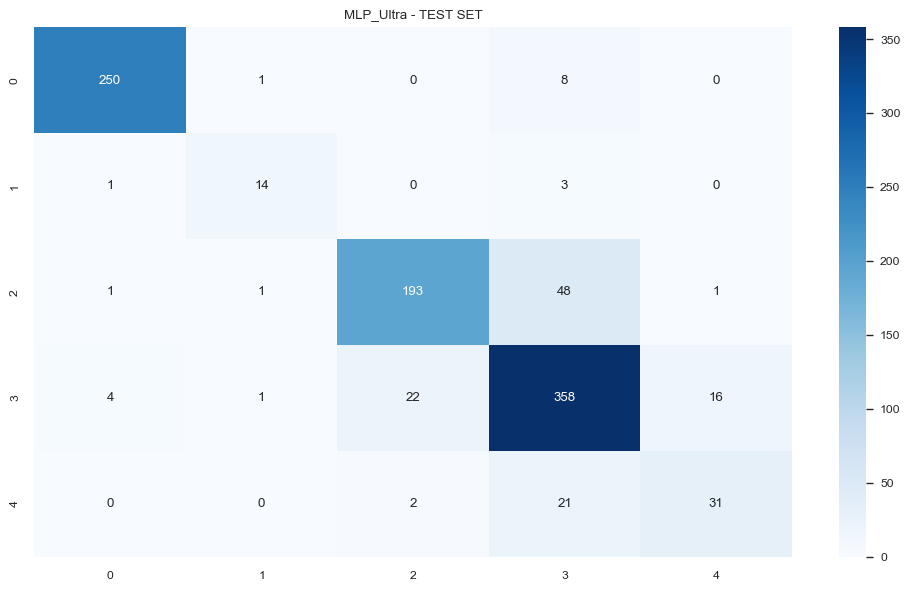

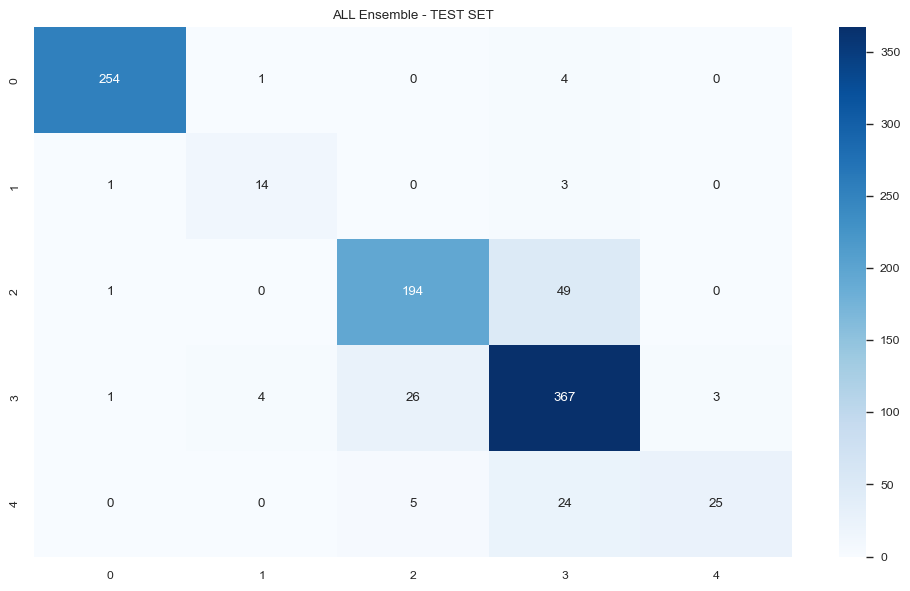

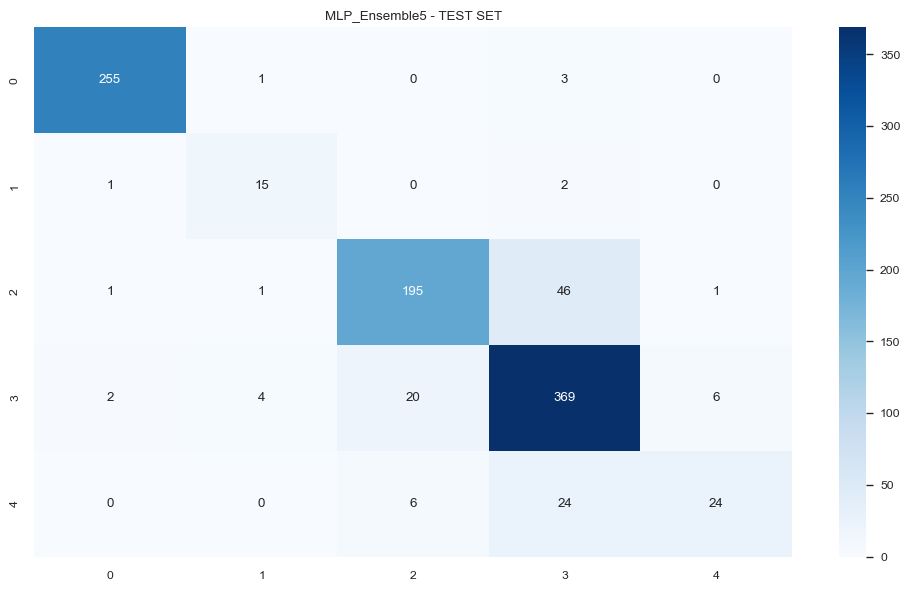

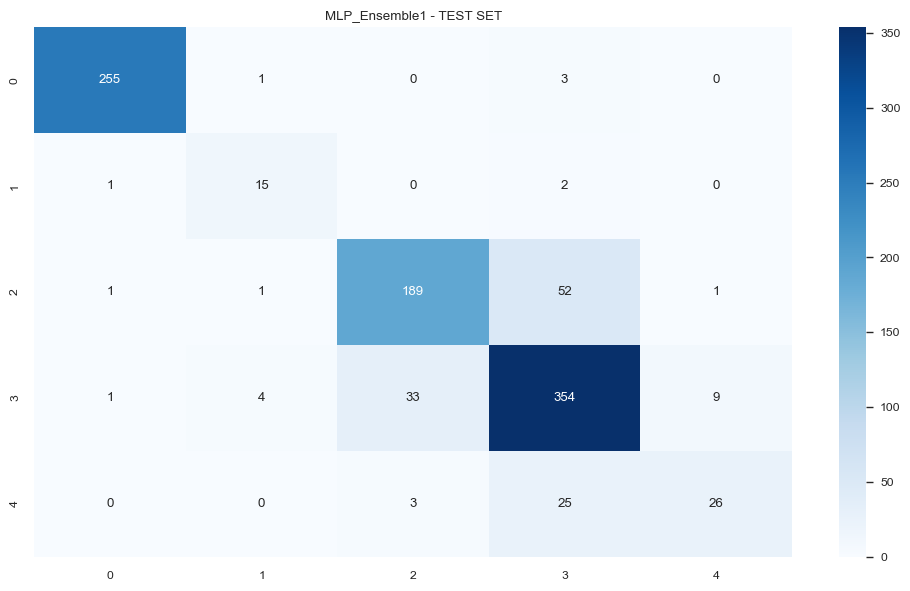

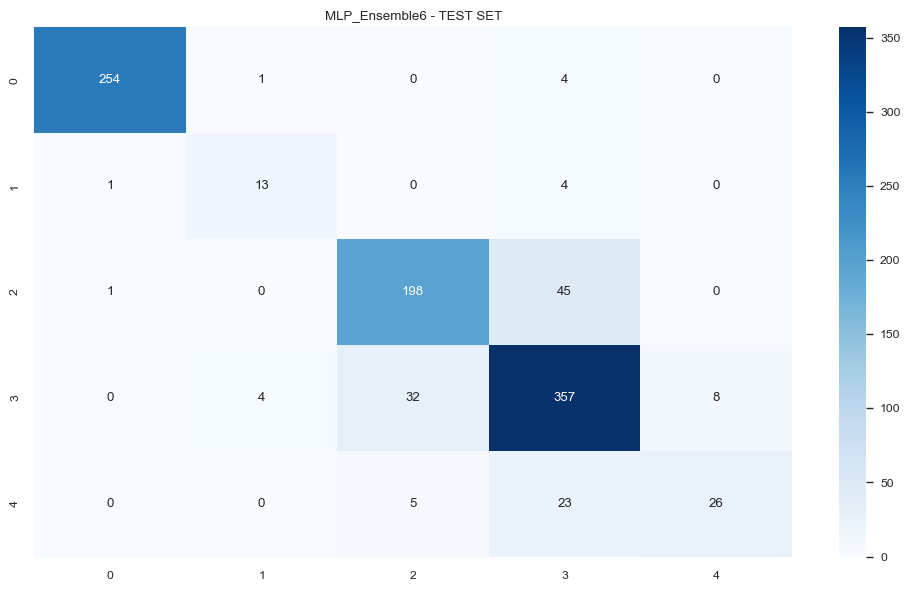

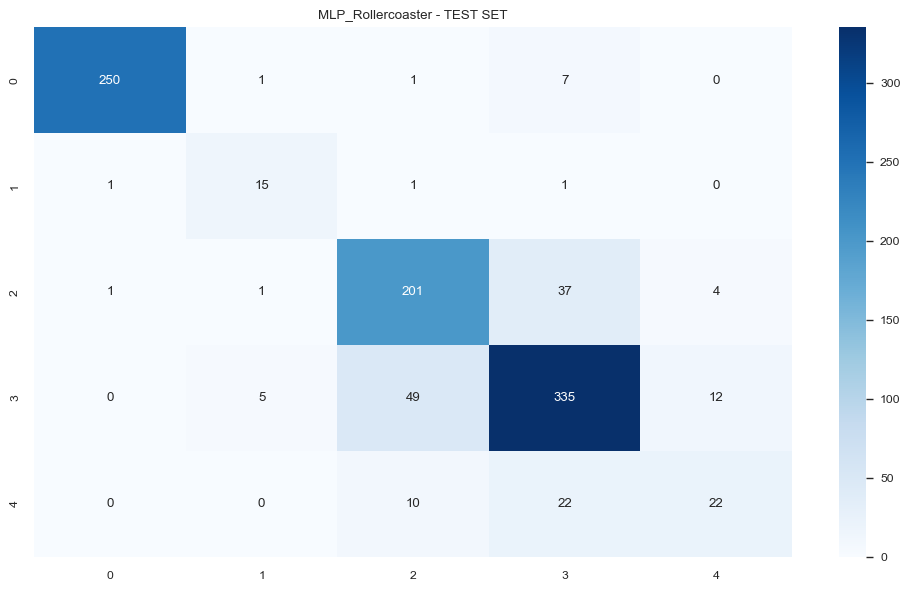

80

In [77]:
# take the best 6 models
best_models = result_df['Macro F1'].sort_values(ascending=False).index[:6]
# add MLP_rollarcoaster
best_models = best_models.append(pd.Index(['MLP_Rollercoaster']))

# plot the confusion matrix of the best models
for model_name in best_models:
	fig, ax = plt.subplots(1, 1, figsize=(10, 6))
	sns.heatmap(cm_dict[model_name], annot=True, cmap='Blues', ax=ax, fmt="d")
	ax.set_title(f'{model_name} - TEST SET')
	plt.tight_layout()
	plt.show()
cm_dict['ALL Ensemble'][:,3].sum() - cm_dict['ALL Ensemble'][3,3]

In [78]:
# import os
# def get_wrong_pred_filename(data_full_path, y_pred):
# 	# load the data
# 	full_data = np.load(data_full_path, allow_pickle=True).item()
# 	X_train, y_train, filename_train = full_data['train']['X'], full_data['train']['y'], full_data['train']['filename']
# 	X_test, y_test, filename_test = full_data['test']['X'], full_data['test']['y'], full_data['test']['filename']

# 	label_to_dir_dict = {
# 	0: f'{BASE_DIR}artifacts_4000/',
# 	1: f'{BASE_DIR}extrahls_4000/',
# 	2: f'{BASE_DIR}murmurs_4000/',
# 	3: f'{BASE_DIR}normals_4000/',
# 	4: f'{BASE_DIR}extrastoles_4000/',
# 	}
     
# 	# find wrong predictions
# 	wrong_pred = np.where(y_pred != y_test)[0]
# 	correct_pred = np.where(y_pred == y_test)[0]

# 	# keep wrong pred only if the actual class was 2 or 4
# 	wrong_pred = [i for i in wrong_pred if y_test[i] in [1,4]]
# 	correct_pred = [i for i in correct_pred if y_test[i] in [1,4]]
	
# 	# recover the filename from the train set labels
# 	filenames = []
# 	for i in wrong_pred:
# 		filenames.append(os.listdir(label_to_dir_dict[int(y_test[i])])[int(filename_test[i])])

# 	count = 0
# 	for name in filenames:
# 		if 'USERAUGMENTED' in name:
# 			count += 1

# 	print(f"Number of wrong predictions: {len(wrong_pred)}")
# 	print(f"Number of wrong predictions with USERAUGMENTED: {count}")

# 	filenames = []
# 	for i in correct_pred:
# 		filenames.append(os.listdir(label_to_dir_dict[int(y_test[i])])[int(filename_test[i])])

# 	count = 0
# 	for name in filenames:
# 		if 'USERAUGMENTED' in name:
# 			count += 1

# 	print(f"Number of correct predictions: {len(correct_pred)}")
# 	print(f"Number of correct predictions with USERAUGMENTED: {count}")
 

# # test the function
# full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

# # train a model
# X_train = full_data['train']['X']
# y_train = full_data['train']['y']
# X_test = full_data['test']['X']
# y_test = full_data['test']['y']

# clf = joblib.load(MODELS_PATH + 'MLP_ultra_none.joblib')
# y_pred = clf.predict(X_test)

# # get the wrong predictions
# get_wrong_pred_filename(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, y_pred)

### EVALUATE MLP ULTRA WITH DATA AUGMENTATION

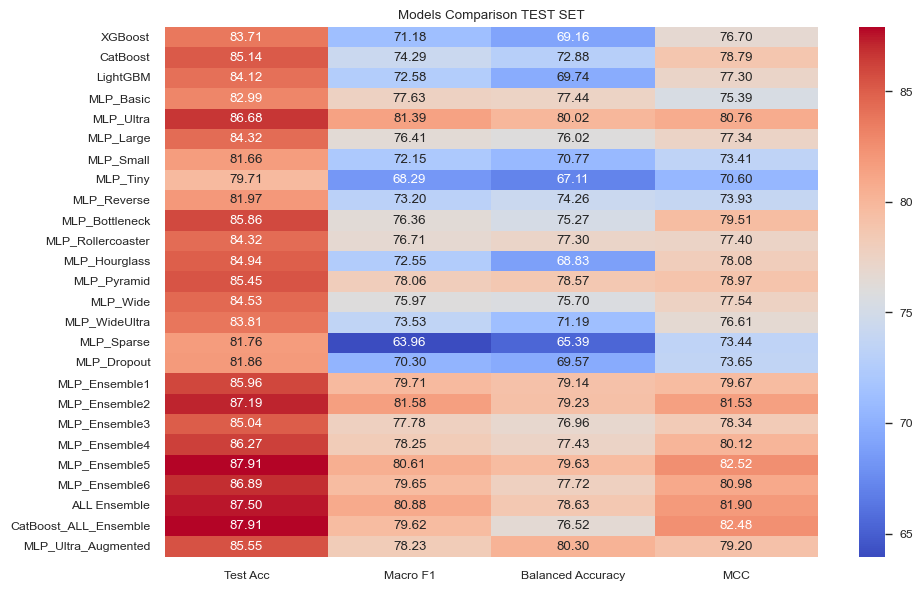

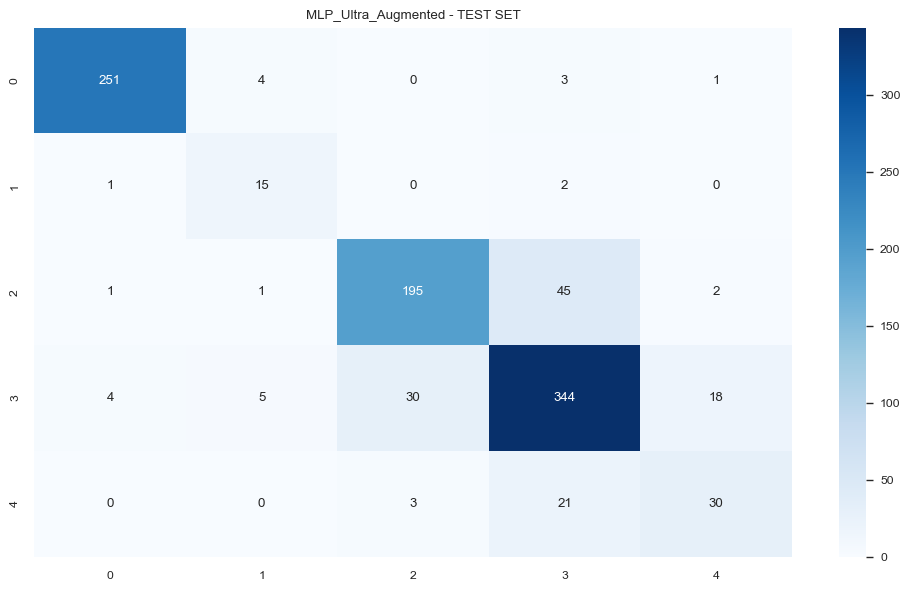

In [79]:
# load the data
num_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}
FEATURES = FEATURES_BASE + 'balanced/priori/'
COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_priori_bal_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + "_USERAUGMENTED.npy"
)
full_data_augmented = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()


# MFCC_position_full_data = [0:30]
# chroma_position_full_data = [30:42]
# zcr_position_full_data = [153:194]

names = np.unique([feat.split(' ')[0] for feat in full_data['features']]).tolist()
for name in names:
	index_to_keep = [[int(feat.split(' ')[1])-1 for feat in full_data['features'] if name in feat]]
	if name == 'MFCC':
		mfcc_full_data_augmented_train = full_data_augmented['train']['X'][:,index_to_keep].reshape(-1,28)
		mfcc_full_data_augmented_test = full_data_augmented['test']['X'][:,index_to_keep].reshape(-1,28)
  
	elif name == 'Chroma':
		chroma_full_data_augmented_train = full_data_augmented['train']['X'][:,30:42][:,index_to_keep].reshape(-1,12)
		chroma_full_data_augmented_test = full_data_augmented['test']['X'][:,30:42][:,index_to_keep].reshape(-1,12)
  
	elif name == 'ZCR':
		zcr_full_data_augmented_train = full_data_augmented['train']['X'][:,153:194][:,index_to_keep].reshape(-1,1)
		zcr_full_data_augmented_test = full_data_augmented['test']['X'][:,153:194][:,index_to_keep].reshape(-1,1)
  
# stack the features
full_data_augmented['train']['X'] = np.concatenate([mfcc_full_data_augmented_train, chroma_full_data_augmented_train, zcr_full_data_augmented_train], axis=1)
full_data_augmented['test']['X'] = np.concatenate([mfcc_full_data_augmented_test, chroma_full_data_augmented_test, zcr_full_data_augmented_test], axis=1)


# add the augmented data to the full data
full_data['train']['X'] = np.vstack([full_data['train']['X'], full_data_augmented['train']['X']])
full_data['train']['y'] = np.hstack([full_data['train']['y'], full_data_augmented['train']['y']])

# train a model
X_train = full_data['train']['X']
y_train = full_data['train']['y']
X_test = full_data['test']['X']
y_test = full_data['test']['y']

clf = MLPClassifier(
    hidden_layer_sizes=(
	   512,
	   256,
	   128,
	   64,
	   32,
    ),
    activation="relu",
    solver="adam",
    random_state=SEED,
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# evaluate
for metric_name, metric in METRICS.items():
    if "macro" in metric_name.lower():
        result_df.loc["MLP_Ultra_Augmented", metric_name] = metric(
            y_test, y_pred, average="macro"
        )
    else:
        result_df.loc["MLP_Ultra_Augmented", metric_name] = metric(y_test, y_pred)
    
cm_dict['MLP_Ultra_Augmented'] = confusion_matrix(y_test, y_pred)

# save the results
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(
    result_df.astype(float) * 100, annot=True, cmap="coolwarm", ax=ax, fmt=".2f"
)
ax.set_title("Models Comparison TEST SET")
plt.tight_layout()
plt.show()

# plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(cm_dict['MLP_Ultra_Augmented'], annot=True, cmap='Blues', ax=ax, fmt="d")
ax.set_title('MLP_Ultra_Augmented - TEST SET')
plt.tight_layout()
plt.show()



In [80]:
# check the shape of the augmented data
print(full_data_augmented['train']['X'].shape)
print(full_data_augmented['test']['X'].shape)

# check the shape of the full data
print(full_data['train']['X'].shape)
print(full_data['test']['X'].shape)

# save the new full data
np.save(FEATURES + 'full_data_filtered_1s_4000hz_28mfcc_12chroma_0cqt_0rms_1zcr_0sc_0sb_0sr_USERAUGMENTED.npy', full_data)

(415, 41)
(5, 41)
(4319, 41)
(976, 41)
